# Descripción
**[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)** es un conjunto de datos de imágenes de artículos de Zalando, que consta de un conjunto de entrenamiento de 60,000 ejemplos y un conjunto de prueba de 10,000 ejemplos. Cada ejemplo es una imagen en escala de grises de 28x28, asociada a una etiqueta de una de las 10 clases. El conjunto de datos sirve como un reemplazo directo del conjunto de datos original [MNIST](http://yann.lecun.com/exdb/mnist/) para la evaluación de algoritmos de aprendizaje automático. Comparte el mismo tamaño de imagen y la estructura de divisiones de entrenamiento y prueba. Puedes obtener más información sobre el conjunto de datos en este [enlace de Kaggle](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

# Carga de datos

In [ ]:
import numpy as np
import pandas as pd

from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf8"))

fashion-mnist_test.csv
fashion-mnist_train.csv
t10k-images-idx3-ubyte
t10k-labels-idx1-ubyte
train-images-idx3-ubyte
train-labels-idx1-ubyte



# Enfoque
En este trabajo, entrenaré un clasificador de Red Neuronal Convolucional muy simple con 1 capa de convolución utilizando la biblioteca de aprendizaje profundo Keras. Primero, el modelo se entrenará durante 10 épocas con un batch size de 256, compilado con la función de pérdida `categorical_crossentropy` y el optimizador `Adam`. Luego, añadiré **data augmentation**, que generará nuevas muestras de entrenamiento mediante rotación, desplazamiento y zoom en las muestras de entrenamiento, y se entrenará durante otras 50 épocas.

Primero dividiré los datos de entrenamiento originales (60,000 imágenes) en un 80% para entrenamiento (48,000 imágenes) y un 20% para validación (12,000 imágenes) para optimizar el clasificador, mientras se conservan los datos de prueba (10,000 imágenes) para evaluar finalmente la precisión del modelo en datos que nunca ha visto. Esto ayudará a determinar si hay un sobreajuste en los datos de entrenamiento y si debo reducir la tasa de aprendizaje y entrenar durante más épocas si la precisión de validación es mayor que la precisión de entrenamiento, o detener el sobreentrenamiento si la precisión de entrenamiento es significativamente mayor que la de validación.


In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

data_train = pd.read_csv('data/fashion-mnist_train.csv')
data_test = pd.read_csv('data/fashion-mnist_test.csv')

# X forms the training images, and y forms the training labels
X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

# Here I split original training data to sub-training (80%) and validation data (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

# X_test forms the test images, and y_test forms the test labels
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Procesamiento de datos
Después de cargar y dividir los datos, los preproceso mediante su remodelado en la forma que la red espera y escalándolos para que todos los valores estén en el intervalo [0, 1]. Previamente, por ejemplo, los datos de entrenamiento se almacenaban en una matriz de forma (60000, 28, 28) de tipo uint8 con valores en el intervalo [0, 255]. Lo transformo en una matriz de tipo float32 de forma (60000, 28 * 28) con valores entre 0 y 1.

In [ ]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_train /= 255

# Prepare the test images
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_test = X_test.astype('float32')
X_test /= 255

# Prepare the validation images
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32')
X_val /= 255

# Modelo 1

## CNN con 1 capa de convolución
En este caso, configuro la CNN para procesar entradas de tamaño *(28, 28, 1)*, que es el formato de las imágenes de FashionMNIST. Hago esto pasando el argumento *input_shape=(28, 28, 1)* a la primera capa.

* La primera capa es una capa *Conv2D* para la operación de **convolución** que extrae características de las imágenes de entrada deslizando un filtro de convolución sobre la entrada para producir un mapa de características. Aquí elijo un kernel_size de 3 x 3.
* La segunda capa es una capa *MaxPooling2D* para la operación de **max-pooling** que reduce la dimensionalidad de cada característica, lo que ayuda a acortar el tiempo de entrenamiento y reducir el número de parámetros. Aquí elijo un pool_size de 2 x 2.
* Para combatir el sobreajuste, añado una capa *Dropout* como tercera capa, una poderosa técnica de regularización. **Dropout** es el método utilizado para reducir el sobreajuste. Obliga al modelo a aprender múltiples representaciones independientes de los mismos datos al desactivar aleatoriamente las neuronas en la fase de aprendizaje. En este modelo, el dropout desactivará aleatoriamente el 20% de las neuronas.
* El siguiente paso es alimentar el último tensor de salida en un conjunto de capas densas, también conocidas como capas **fully-connected**. Estos clasificadores conectados densamente procesan vectores, que son 1D, mientras que la salida actual es un tensor 3D. Por lo tanto, necesito poner en **flatten** las salidas 3D a 1D, y luego añadir 2 capas densas encima.
* Realizo una clasificación de 10 clases (ya que hay 10 clases de imágenes de moda), utilizando una capa final con 10 salidas y una activación softmax. La activación **Softmax** me permite calcular la salida en función de las probabilidades. A cada clase se le asigna una probabilidad y la clase con la probabilidad máxima es la salida del modelo para la entrada.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(10, activation='softmax'))

Para compilar el modelo, elijo **categorical_crossentropy** como función de pérdida (que es relevante para un problema de clasificación multiclase y etiqueta única) y el optimizador **Adam**.
* Pondre loss igual a categorical_crossentropy ya que calcula la tasa de error entre el valor predicho y el valor original. Adema se utiliza la su forma categórica porque hay 10 clases para predecir. Si hubiera 2 clases, habría utilizado binary_crossentropy.
* Cabe mencionar que optimizador Adam es una mejora sobre SGD (Descenso de Gradiente Estocástico).


In [ ]:
cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Vizualizamos la configuración del modelo:



In [ ]:
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               692352    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


## Entrenar el modelo
Entrenamos el modelo con los conjuntos de train y validation con el batch_size y las epocas que mencionamos anteriormente.

In [ ]:
history1 = cnn1.fit(X_train, y_train,
          batch_size=256,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 30s 621us/step - loss: 0.5460 - acc: 0.8085 - val_loss: 0.3817 - val_acc: 0.8690
Epoch 2/10
48000/48000 [==============================] - 31s 649us/step - loss: 0.3627 - acc: 0.8712 - val_loss: 0.3390 - val_acc: 0.8828
Epoch 3/10
48000/48000 [==============================] - 30s 635us/step - loss: 0.3191 - acc: 0.8868 - val_loss: 0.3118 - val_acc: 0.8906
Epoch 4/10
48000/48000 [==============================] - 31s 645us/step - loss: 0.2957 - acc: 0.8940 - val_loss: 0.3012 - val_acc: 0.8938
Epoch 5/10
48000/48000 [==============================] - 42s 865us/step - loss: 0.2718 - acc: 0.9034 - val_loss: 0.2881 - val_acc: 0.8968
Epoch 6/10
48000/48000 [==============================] - 38s 800us/step - loss: 0.2587 - acc: 0.9087 - val_loss: 0.2890 - val_acc: 0.8938
Epoch 7/10
48000/48000 [==============================] - 30s 623us/step - loss: 0.2461 - acc: 0.9108 - val_loss: 0.

In [ ]:
score1 = cnn1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 0.2484699842095375
Test accuracy: 0.9104


Mi precisión es del 91.04%, ¡Sugoiiiiiiii!
Pero puede ser mejor si hacemos algo mas a los datos de entrada del modelo.

## Data Augmentation
El sobreajuste puede ser causado por tener muy pocas muestras para aprender, lo que me impide entrenar un modelo que pueda generalizar a nuevos datos. Si tuviera datos infinitos, mi modelo estaría expuesto a todos los aspectos posibles de la distribución de datos que tengo: nunca sobreajustaría.

El **Data Augmentation** adopta el enfoque de generar más datos de entrenamiento a partir de las muestras de entrenamiento existentes, mediante la aplicación de una serie de transformaciones aleatorias que producen imágenes creíbles. El objetivo es que durante el entrenamiento, mi modelo nunca vea la misma imagen exacta dos veces. Esto ayudara a exponer a que vea varios lados de una mondeda.

Por suerte en Keras, esto se puede hacer con ayuda de **ImageDataGenerator**, el cual esta configurado de la siguiente manera.
* *rotation_range* es un valor en grados (0-180), un rango en el que se rotarán aleatoriamente las imágenes.
* *width_shift* y *height_shift* son rangos (como fracción del ancho o alto total) en los que se trasladarán aleatoriamente las imágenes vertical u horizontalmente.
* *shear_range* se utiliza para aplicar aleatoriamente una inclinacion a cada imagen.
* *zoom_range* se utiliza para aplicar aleatoriamente zoom dentro de las imágenes.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=256)
val_batches = gen.flow(X_val, y_val, batch_size=256)

Ahora si a lo que nos ruge chencha provemos nuevamente

In [ ]:
history1 = cnn1.fit_generator(batches, steps_per_epoch=48000//256, epochs=50,
                    validation_data=val_batches, validation_steps=12000//256, use_multiprocessing=True)

Epoch 1/50
187/187 [==============================] - 35s 188ms/step - loss: 0.3706 - acc: 0.8633 - val_loss: 0.3606 - val_acc: 0.8665
Epoch 2/50
187/187 [==============================] - 40s 214ms/step - loss: 0.3636 - acc: 0.8654 - val_loss: 0.3414 - val_acc: 0.8747
Epoch 3/50
187/187 [==============================] - 45s 243ms/step - loss: 0.3503 - acc: 0.8685 - val_loss: 0.3401 - val_acc: 0.8750
Epoch 4/50
187/187 [==============================] - 38s 205ms/step - loss: 0.3487 - acc: 0.8709 - val_loss: 0.3428 - val_acc: 0.8755
Epoch 5/50
187/187 [==============================] - 36s 195ms/step - loss: 0.3351 - acc: 0.8756 - val_loss: 0.3373 - val_acc: 0.8718
Epoch 6/50
187/187 [==============================] - 38s 202ms/step - loss: 0.3314 - acc: 0.8778 - val_loss: 0.3354 - val_acc: 0.8736
Epoch 7/50
187/187 [==============================] - 38s 201ms/step - loss: 0.3313 - acc: 0.8758 - val_loss: 0.3363 - val_acc: 0.8735
Epoch 8/50
187/187 [==============================] - 3

In [ ]:
score1 = cnn1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 0.22102486880123615
Test accuracy: 0.9229


Gracias al **Data Augmentation** ajuste mejor los datos al modelo. ¡Obtuve un fabuloso 92.29%!

## Resultados
Grafiquemos la precisión de entrenamiento y validación, así como la pérdida de en ambas.

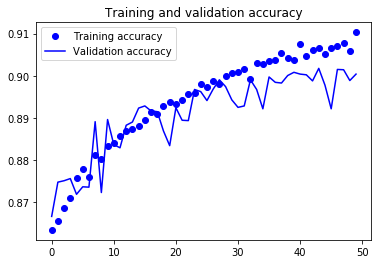

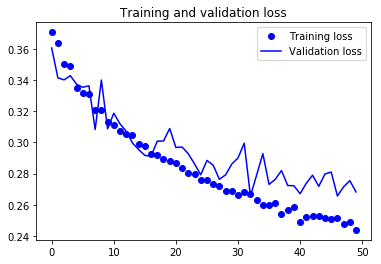

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history1.history['acc']
val_accuracy = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Las curvas de perdida y precisión en entrenamiento y validación son concistentes entre si por lo que podemos generar buenas predicciones cercanas a los datos reales, aunque todavia puede mejorarse

## Informe de clasificación
Puedo resumir el rendimiento de mi clasificador de la siguiente manera:


In [ ]:
# get the predictions for the test data
predicted_classes = cnn1.predict_classes(X_test)

# get the indices to be plotted
y_true = data_test.iloc[:, 0]
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.88      0.88      0.88      1000
    Class 1       0.99      0.99      0.99      1000
    Class 2       0.93      0.83      0.87      1000
    Class 3       0.92      0.94      0.93      1000
    Class 4       0.86      0.90      0.88      1000
    Class 5       0.98      0.98      0.98      1000
    Class 6       0.77      0.79      0.78      1000
    Class 7       0.96      0.97      0.96      1000
    Class 8       0.98      0.99      0.99      1000
    Class 9       0.98      0.96      0.97      1000

avg / total       0.92      0.92      0.92     10000



Es evidente que el clasificador tiene un rendimiento deficiente para la clase 6 en cuanto a precision y recall. Para la clase 4, el clasificador carece ligeramente de precision; mientras que para la clase 2, carece ligeramente de recall.

## Predicción

Aquí hay un subconjunto de clases predichas correctamente:

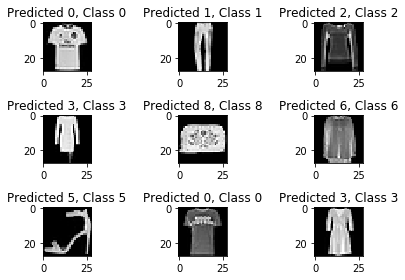

In [ ]:
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_true[correct]))
    plt.tight_layout()


Y aquí hay un subconjunto de clases predichas incorrectamente.

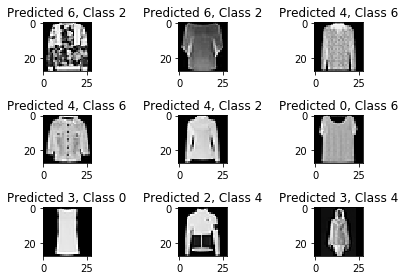

In [ ]:
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_true[incorrect]))
    plt.tight_layout()